## Cliff-walking

1. Undiscounted, episodic task.
2. Task is to move from start state (S) to goal state(G)
3. Actions : Up, Down, Left and Right.
4. Deterministic environment.
5. Reward of -1 on all transitions, except those into the region marked as "Cliff". Stepping into this region incurs a reward of -100 and sends the agent instantly to the start state.

<img src="images/M5A1-P1.png" alt="M4A1-P3" width="500"/>

In [1]:
import gym
import numpy as np
from typing import Callable, List, Tuple, Sequence
from collections import defaultdict
import sys
import plots
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
class cliff_walking_grid_world(object):
    def __init__(self, n_row : int = 4, n_col : int = 12) -> None:
        self.n_row = n_row
        self.n_col = n_col
        self.cliff_states = [(n_row-1,x) for x in range(1,n_col-1)]
        self.start_state = (n_row-1,0)
        self.goal_state = (n_row-1,n_col-1)
        self.n_actions = 4
        self.action_space = np.arange(self.n_actions) #0:up , 1:right, 2:down, 3:left
        self.reset()
    
    def reset(self) -> object:
        self.cur_state = self.start_state
        return self.cur_state
        
    def step(self, action : int) -> object:
        assert action in self.action_space
        next_state = None
        reward = None
        done = False
        info = None
        if(action == 0):
            if(self.cur_state[0] == 0):
                next_state = self.cur_state
            else:
                next_state = (self.cur_state[0]-1,self.cur_state[1])
        if(action == 1):
            if(self.cur_state[1] == self.n_col-1):
                next_state = self.cur_state
            else:
                next_state = (self.cur_state[0], self.cur_state[1]+1)
        if(action == 2):
            if(self.cur_state[0] == self.n_row-1):
                next_state = self.cur_state
            else:
                next_state = (self.cur_state[0]+1, self.cur_state[1])
        if(action == 3):
            if(self.cur_state[1] == 0):
                next_state = self.cur_state
            else:
                next_state = (self.cur_state[0], self.cur_state[1]-1)
        
        
                
        if(next_state in self.cliff_states):
            reward = -100
            next_state = self.start_state
        else:
            reward = -1
        
        if(next_state == self.goal_state):
            done = True
            
        self.cur_state = next_state
            
        return next_state, reward, done, info

In [3]:
rewards_dict = {}

### SARSA

<img src="images/M5A1-P2.png" alt="M4A1-P3" width="500"/>

In [4]:
class sarsa(object):
    def __init__(self, env : cliff_walking_grid_world, alpha : float = 0.5, epsilon : float = 0.1, gamma : float = 1.0):
        self.env = env
        self.alpha = alpha
        self.epsilon = epsilon
        self.gamma = gamma
        self.Q = defaultdict(lambda: np.zeros(env.n_actions))
        
    def policy(self, state : Tuple) -> int:
        eps = np.random.random()
        if(eps <= self.epsilon):
            return np.random.choice(self.env.action_space)
        else:
            return np.random.choice(np.where(self.Q[state] == np.max(self.Q[state]))[0])
    
    def update_q(self, state : Tuple, action : int, reward : float, next_state : Tuple, next_action : int):
        self.Q[state][action] = self.Q[state][action] + self.alpha * \
                                (reward + self.gamma*self.Q[next_state][next_action] - self.Q[state][action])
        
    def plot_policy(self) -> None:
        fig, ax = plt.subplots()
        for j in range(self.env.n_col):
            for i in range(self.env.n_row):
                c = np.argmax(self.Q[(i,j)])
                if(c == 0):
                    action = 'U'
                if(c == 1):
                    action = 'R'
                if(c == 2):
                    action = 'D'
                if(c == 3):
                    action = 'L'
                if((i,j) in self.env.cliff_states):
                    action = '-'
                if((i,j) == self.env.goal_state):
                    action = 'G'
                ax.text(j+0.5, i+0.5, action, va='center', ha='center')  
        ax.set_xlim(0, self.env.n_col)
        ax.set_ylim(self.env.n_row, 0)
        ax.set_xticks(np.arange(self.env.n_col))
        ax.set_yticks(np.arange(self.env.n_row))
        ax.grid()
        plt.show()

Run 100/100.

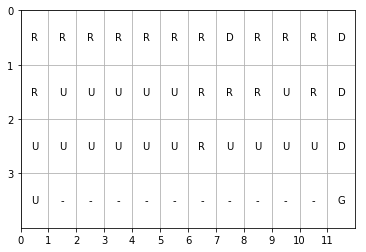

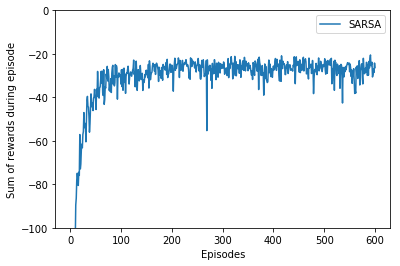

In [5]:
num_runs = 100
num_episodes = 600

rewards_all_run = []
for run_number in range(num_runs):
    if((run_number+1)%10 == 0):
        print("\rRun {}/{}.".format(run_number+1, num_runs), end="")
        sys.stdout.flush()
    env = cliff_walking_grid_world()
    agent = sarsa(env)
    rewards = []

    for episode_number in range(num_episodes):
        state = env.reset()
        action = agent.policy(state)
        reward_sum = 0
        while(1):
            next_state, reward, done, info = env.step(action)
            next_action = agent.policy(next_state)
            agent.update_q(state, action, reward, next_state, next_action)
            reward_sum = reward_sum + reward 
            state = next_state
            action = next_action
            if(done):
                rewards.append(reward_sum)
                break
    rewards_all_run.append(rewards)

agent.plot_policy()

rewards_dict['SARSA'] = rewards_all_run
plots.plot_avg_rewards_cliff_walking(rewards_dict)

### Q-Learning

<img src="images/M5A1-P3.png" alt="M4A1-P3" width="500"/>

In [6]:
class q_learning(object):
    def __init__(self, env : cliff_walking_grid_world, alpha : float = 0.5, epsilon : float = 0.1, gamma : float = 1.0):
        self.env = env
        self.alpha = alpha
        self.epsilon = epsilon
        self.gamma = gamma
        self.Q = defaultdict(lambda: np.zeros(env.n_actions))
        
    def policy(self, state : Tuple) -> int:
        '''
        @parameters:
        state : Tuple representing the state
        
        @doc
        This is the epsilon-greedy behaviour policy. Returns the action selected by the policy.
        '''
        eps = np.random.random()
        if(eps <= self.epsilon):
            return np.random.choice(self.env.action_space)
        else:
            return np.random.choice(np.where(self.Q[state] == np.max(self.Q[state]))[0])
    
    def update_q(self, state, action, reward, next_state):
        self.Q[state][action] = self.Q[state][action] + self.alpha * \
                                (reward + self.gamma*np.max(self.Q[next_state]) - self.Q[state][action])
        
    def plot_policy(self) -> None:
        fig, ax = plt.subplots()
        for j in range(self.env.n_col):
            for i in range(self.env.n_row):
                c = np.argmax(self.Q[(i,j)])
                if(c == 0):
                    action = 'U'
                if(c == 1):
                    action = 'R'
                if(c == 2):
                    action = 'D'
                if(c == 3):
                    action = 'L'
                if((i,j) in self.env.cliff_states):
                    action = '-'
                if((i,j) == self.env.goal_state):
                    action = 'G'
                ax.text(j+0.5, i+0.5, action, va='center', ha='center')  
        ax.set_xlim(0, self.env.n_col)
        ax.set_ylim(self.env.n_row, 0)
        ax.set_xticks(np.arange(self.env.n_col))
        ax.set_yticks(np.arange(self.env.n_row))
        ax.grid()
        plt.show()

Run 100/100.

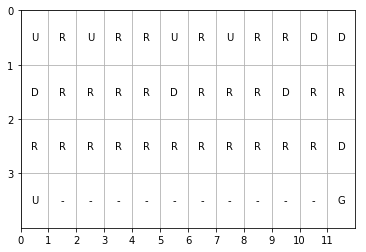

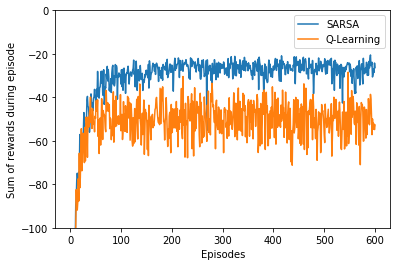

In [7]:
num_runs = 100
num_episodes = 600

rewards_all_run = []
for run_number in range(num_runs):
    if((run_number+1)%10 == 0):
        print("\rRun {}/{}.".format(run_number+1, num_runs), end="")
        sys.stdout.flush()
    env = cliff_walking_grid_world()
    agent = q_learning(env)
    rewards = []

    for episode_number in range(num_episodes):
        state = env.reset()
        reward_sum = 0
        while(1):
            action = agent.policy(state)
            next_state, reward, done, info = env.step(action)
            agent.update_q(state, action, reward, next_state)
            reward_sum = reward_sum + reward 
            state = next_state
            if(done):
                rewards.append(reward_sum)
                break
    rewards_all_run.append(rewards)

agent.plot_policy()
rewards_dict['Q-Learning'] = rewards_all_run
plots.plot_avg_rewards_cliff_walking(rewards_dict)